In [119]:
import glob 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('ndc.csv')
df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d') #날짜형식으로 변환
df=df[['날짜','현재유량']]
df.columns=['date','inflow']
df

,date,inflow
0,1996-01-01,0.86
1,1996-01-02,0.86
2,1996-01-03,0.86
3,1996-01-04,0.86
4,1996-01-05,0.72
...,...,...
9204,2024-05-20,1.54
9205,2024-05-21,1.49
9206,2024-05-22,1.42
9207,2024-05-23,1.34


1163


<Axes: >

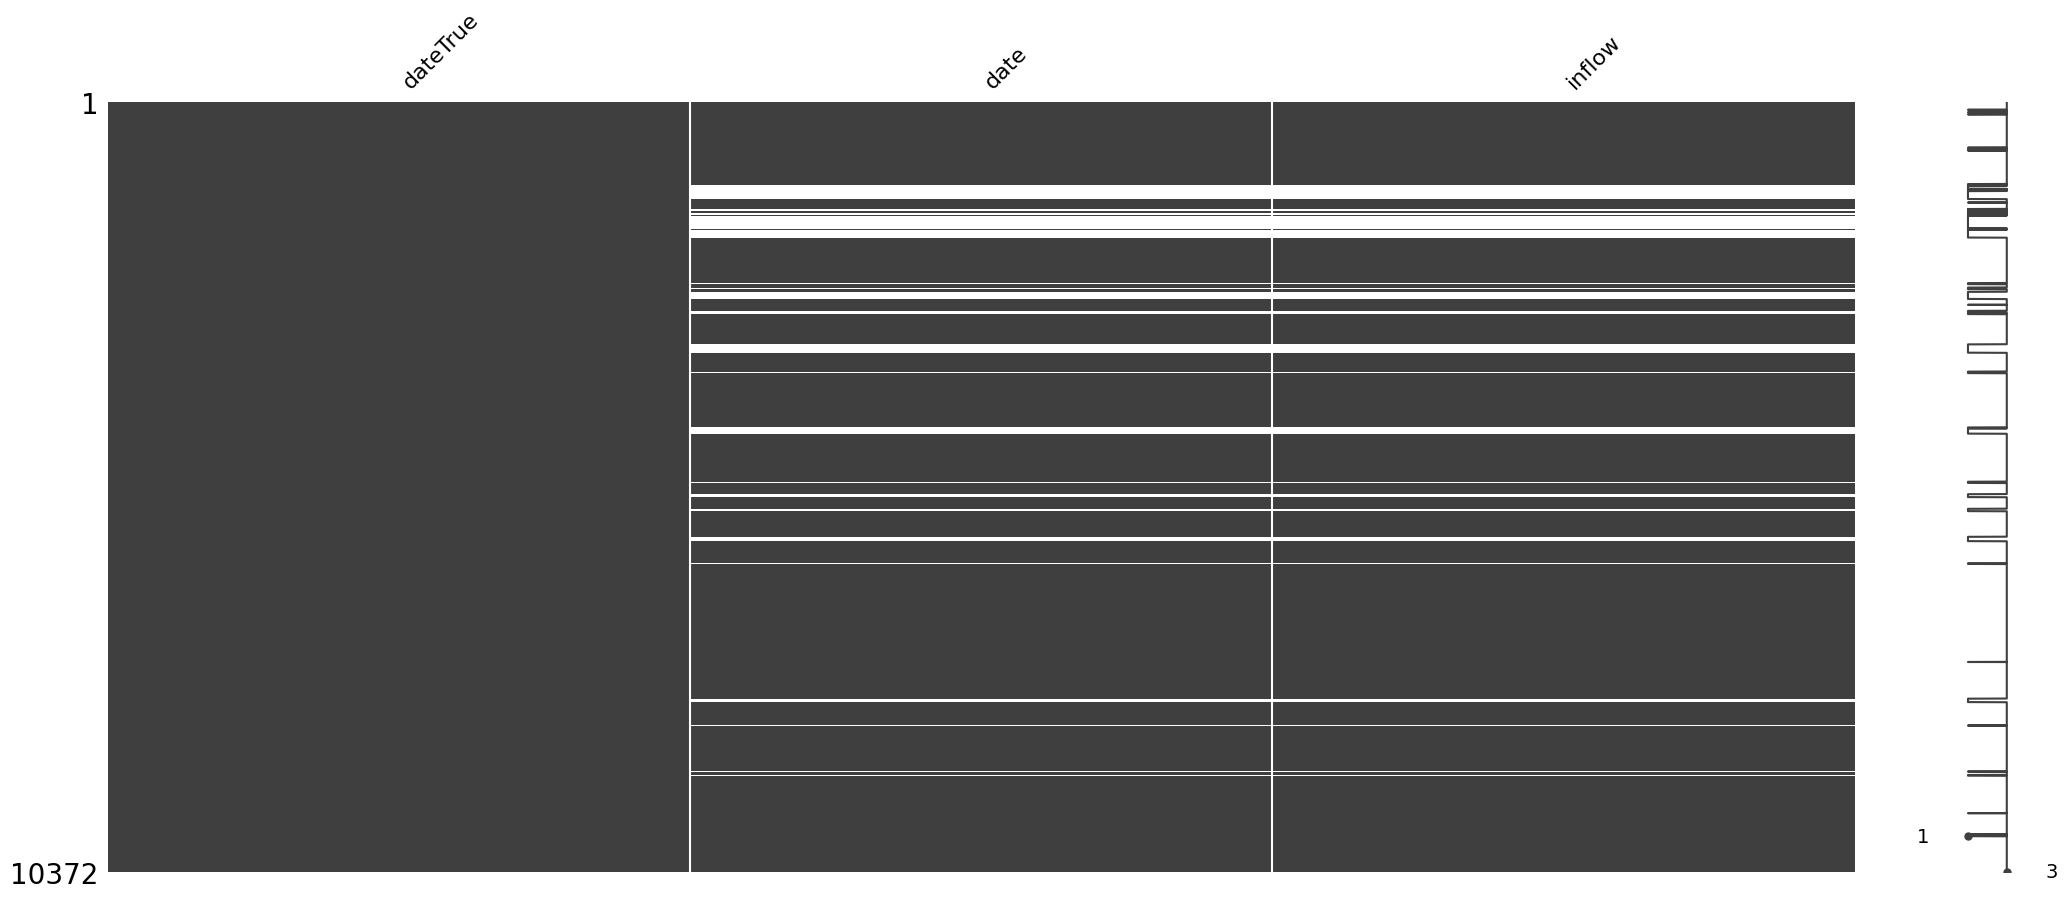

In [120]:
drange=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
drnge_test=pd.merge(drange.to_frame(), df, left_on=0, right_on='date', how='left')
drnge_test.rename(columns={0:'dateTrue'}, inplace=True)
print(drnge_test['date'].isna().sum()) #누락된 날짜 확인
df.sort_values(by='date', inplace=True) #날짜순으로 정렬

msno.matrix(drnge_test) #누락된 유량 데이터 확인

In [121]:
# 계절별 유량 분포
winter = drnge_test[drnge_test['dateTrue'].dt.month.isin([12, 1, 2])]
spring = drnge_test[drnge_test['dateTrue'].dt.month.isin([3, 4, 5])]
summer = drnge_test[drnge_test['dateTrue'].dt.month.isin([6, 7, 8])]
fall = drnge_test[drnge_test['dateTrue'].dt.month.isin([9, 10, 11])]
print('winter nan:', winter['inflow'].isna().sum(), '\nspring nan:', spring['inflow'].isna().sum(), '\nsummer nan:', summer['inflow'].isna().sum(), '\nfall nan:', fall['inflow'].isna().sum())
#print('Winter:', winter['inflow'].describe(), '\nSpring:', spring['inflow'].describe(), '\nSummer:', summer['inflow'].describe(), '\nFall:', fall['inflow'].describe())
#winter2 = winter.dropna();spring2 = spring.dropna();summer2 = summer.dropna();fall2 = fall.dropna()
#plt.figure(figsize=(10,5))
#plt.subplot(2,2,1);plt.hist(winter2['inflow'], bins=100);plt.xlim(0, 100);plt.title('Winter')
#plt.subplot(2,2,2);plt.hist(spring2['inflow'], bins=100);plt.xlim(0, 100);plt.title('Spring')
#plt.subplot(2,2,3);plt.hist(summer2['inflow'], bins=100);plt.xlim(0, 100);plt.title('Summer')
#plt.subplot(2,2,4);plt.hist(fall2['inflow'], bins=100);plt.xlim(0, 100);plt.title('Fall')



winter nan: 499 
spring nan: 284 
summer nan: 199 
fall nan: 181


In [122]:
import numpy as np
# 의심1: 겨울철, 초봄철 유량이 누락된 경우가 많음. 그 이유는?
# -> 유량이 0인 시기에 전원이 끊겼을 가능성이 있음, 따라서 양 끝이 0부터 q75인경우 NaN값을 0으로 채워줌
def fill_v_between_v(series, upper_threshold, lower_thereshold=0, fill=0):
    res = series.copy()
    stru_area = np.where((res >= lower_thereshold) & (res <= upper_threshold))[0]
    for i in range(len(stru_area) - 1):
        start = stru_area[i]
        end = stru_area[i + 1]
        if np.all(np.isnan(series[start+1:end])):  # Check if all values between start and end are NaN
            res[start+1:end] = fill
    return res
winter['inflow']=fill_v_between_v(winter['inflow'],upper_threshold=winter['inflow'].quantile(0.75))
spring['inflow']=fill_v_between_v(spring['inflow'],upper_threshold=spring['inflow'].quantile(0.75))
summer['inflow']=fill_v_between_v(summer['inflow'],upper_threshold=summer['inflow'].quantile(0.75))
fall['inflow']=      fill_v_between_v(fall['inflow'],upper_threshold=fall['inflow'].quantile(0.75))
print(f'winter nan: {winter["inflow"].isna().sum()}');print(f'spring nan: {spring["inflow"].isna().sum()}');print(f'summer nan: {summer["inflow"].isna().sum()}');print(f'fall nan: {fall["inflow"].isna().sum()}')

winter nan: 256
spring nan: 140
summer nan: 152
fall nan: 47


595
452


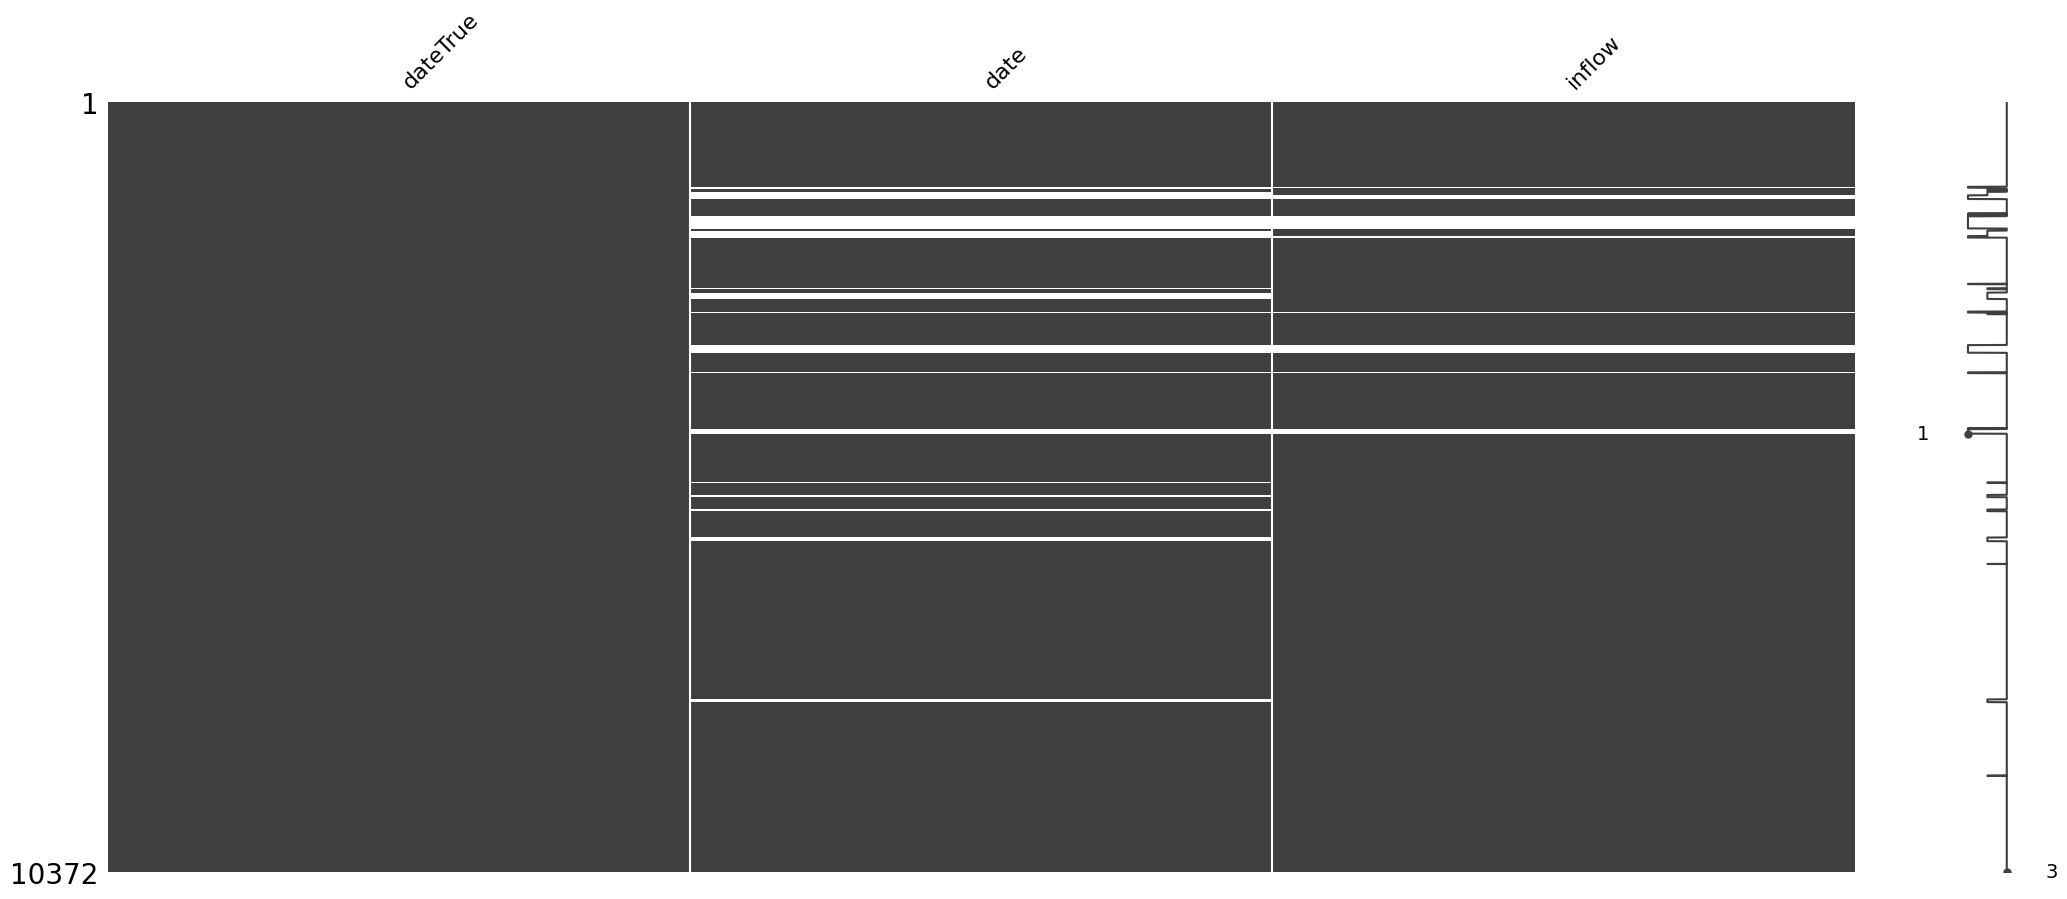

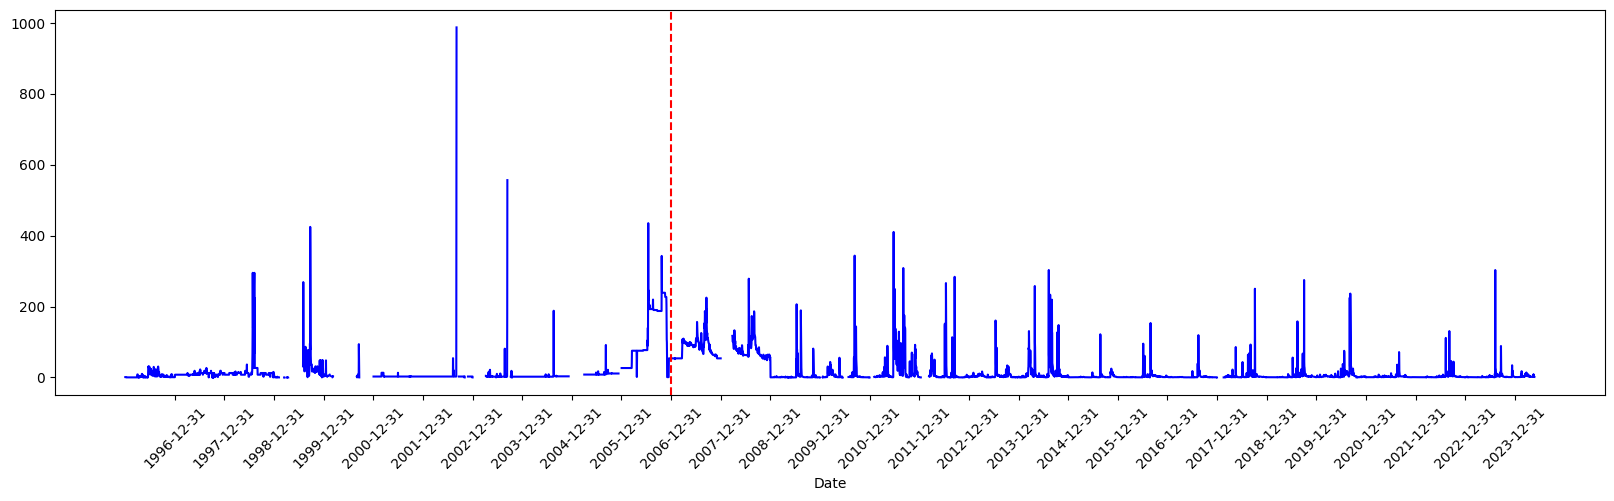

In [123]:
reunion=pd.concat([winter, spring, summer, fall]).sort_values(by='dateTrue').reset_index(drop=True)
print(reunion['inflow'].isna().sum())
reunion.ffill(inplace=True, limit=10) 
msno.matrix(reunion) #누락된 유량 데이터 확인
#앞에서부터 3개까지 NaN값을 채워줌, 
#의심2: ffill을 한 이유는? 
#-> 만일 고장이라면 유량계를 고친 이유는 특정 유량을 관측하기 위함 일 수 있음. 
#따라서 bfill을 하면 unique한 값이 채워질 가능성이 높음, 그걸 방지하기 위해 ffill을 함
print(reunion['inflow'].isna().sum())
reunion['inflowNA'] = reunion['inflow'].isna()
reunion['inflowNA'].apply(lambda x: 1 if x==True else np.nan)
reunion['inflowNA'].fillna(0, inplace=True)
ax, fig = plt.subplots(figsize=(20,5))
fig.plot(reunion['date'], reunion['inflow'], 'b-')
plt.xlabel('Date')
plt.xticks(pd.date_range(start=reunion['date'].min(), end=reunion['date'].max(), freq='Y'), rotation=45)
plt.axvline(x=pd.to_datetime('2007-01-01'), color='r', linestyle='--')

In [125]:
reunion2007=reunion[reunion['dateTrue']>='2007-01-01']
print(reunion2007['inflow'].isna().sum())
reunion2007['inflow'].interpolate(method='linear', inplace=True)
print(reunion2007['inflow'].isna().sum())
#패턴을 보면 2007년 이후로는 유량이 일정한 패턴을 보이며 특이치가 없음. 따라서 2007년 이후로 데이터를 선정하고,
# bfill을 통해 NaN값을 채울 수 없는 구간은 어쩔 수 없이 선형보간을 통해 NaN값을 채워줌
reunion2007.to_csv('inflow_Hoesangyo_Bridge.csv', index=False)

64
0


In [ ]:
pd.set_option('display.max_columns', 500)
import glob as glob
import pandas as pd
ASOSfileset_raw=glob.glob('OBS_ASOS_DD*.csv')
asos_data=[]
for f in ASOSfileset_raw:
    df=pd.read_csv(f, encoding='cp949')
    asos_data.append(df)
asos=pd.concat(asos_data)
print(asos.duplicated().sum())
asos.drop_duplicates(inplace=True)
asos['일시']=pd.to_datetime(asos['일시'], format='%Y-%m-%d')
asos.sort_values(by='일시',inplace=True)
asos.set_index('일시', inplace=True)
asos_fin=asos[['일강수량(mm)', '최고기온(°C)', '최저기온(°C)', '평균 풍속(m/s)', '평균 상대습도(%)', '합계 일사량(MJ/m2)','지점']]
asos_fin.columns=['prcp','tmax','tmin','wspd','rhum','rsds','지점']
asos_fin.head(5)
asos_fin['prcp'].fillna(0, inplace=True)
print(asos_fin.isna().sum())
asos_fin.isna()[asos_fin['rsds'].isna()]
asos_fin.bfill(inplace=True,limit=2)
asos_fin['rsds'].interpolate(method='linear', inplace=True)
print(asos_fin.isna().sum())
asos_fin=asos_fin[asos_fin.index>='2007-01-01']
asos_fin.head(2)

2
prcp     0
tmax     0
tmin     0
wspd     2
rhum     0
rsds    11
지점       0
dtype: int64
prcp    0
tmax    0
tmin    0
wspd    0
rhum    0
rsds    0
지점      0
dtype: int64


,prcp,tmax,tmin,wspd,rhum,rsds,지점
일시,,,,,,,
2007-01-01,0.0,10.3,1.2,2.5,42.0,7.92,105
2007-01-02,8.0,8.6,3.7,2.6,73.8,5.09,105


In [ ]:
asos_fin.to_csv('asos105.csv')